# Removing RFI's from data
This notebook is meant to exclude rfi's by deleting the frequency channels with an of pulse rms value is n-$\sigma$ away from 

Definition of noise and signal and SNR
1. Noise : we define noise as the standard deviation of off pulse values
2. Signal: It is the sum of all the values under the puls.
   Note that since bin width is kept constant for all pulses(subints/channels) Signal value if proportional to the area under the pulse.
3. SNR   : The signal to noise ratio is defined as ratio of above two quantities

Procedure we will follow:
1. Compute off pulse noise value (SD) as defined above for all frequency channels 
2. Compute off pulse mean value for all frequancy channels
3. We then take an estimator, as sample mean/median value for an estimate.
   i.e. mean/median of values obtained in 1.
   and mean/median of values obtained in 2.
4. The estimator will give us an estimate of 

What we assume and why we take the above steps:
1. We assume that noise for a signle frequency channel is a gaussian random variable i.e Norm($\mu({\nu})$,$\sigma({\nu})$).
2. And if that noise is white, then it should be same for all frequency channels.
   Thus noise for all frequency channels is an IID. i.e. Norm($\mu$,$\sigma$).
3. We need an estimator for $\mu$ and $\sigma$ if the distribution.
   Let $\hat{\mu}$,$\hat{\sigma}$ denote the estimator of $\mu$,$\sigma$.
   Let $\mu_{\nu}$,$\sigma_{\nu}$ denote the sample-mean,sample-standard-deviation of single frequency channel.
4. Estimators:
    1. Estimator 1:
      $\hat{\mu}$ = $\frac{1}{N_{chan}}$ $\sum_{\nu} \mu_{\nu}$,
      $\hat{\sigma}$ = $\frac{1}{N_{chan}}$ $\sum_{\nu} \sigma_{\nu}$
    2. Estimator 2:
      $\hat{\mu}$ = median( {$\mu_{\nu}$} ) ,
      $\hat{\sigma}$ = median({$\sigma_{\nu}$})
    3. Estimator 3:
       $\hat{\sigma} ^2 $ = $\frac{1}{N_{chan}\times{n_bins}}$ $\sum_{\nu} \sum_{bins}$($x_{bin} - \hat{\mu} $)$^2$

7. So we consider two hypothesis:
   1. $H_0$: The frequency channel is dominated by white noise.
   2. $H_1$: The frequency channel is not dominated by white noise, i.e. dominated by RFI's.
8. Hypothesis testing:
   1. Test 1:
    If $\bar{\mu_{\nu}}$ is "n"-$\sigma$ away from $\mu$, accept $H_1$
    Else $H_0$
   2. Test 2:

    add an or condition to above, $\bar{\sigma}$ is "n"-$\sigma'$ away

In [32]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib qt
from astropy.io import fits
import pandas as pd
from scipy.optimize import curve_fit

In [4]:
import psrchive

In [24]:
#Estimator A.
def SNR(Dataset,Pulse_start_bin,Pulse_end_bin):
    data1=Dataset[0:Pulse_start_bin]
    data2=Dataset[Pulse_start_bin:Pulse_end_bin]
    data3=Dataset[Pulse_end_bin:-1]
    #mean=np.mean([data1,data3])
    #ssr=(1/(512-(Pulse_end_bin-Pulse_start_bin))) *  (np.sum( ) + np.sum( (Dataset[Pulse_start_bin:-1])**2 ) )
    noise_sd_nu=np.std(np.concatenate([data1,data3]))
    noise_mean_nu=np.mean(np.concatenate([data1,data3]))
    signal=np.sum(data2)
    #off_pstd = np.sqrt( ssr )
    #on_pstd = np.sqrt((1/( Pulse_end_bin-Pulse_start_bin) )*np.sum((Dataset[Pulse_start_bin:Pulse_end_bin])**2) )
    #pstd=np.std(Dataset)
    snr=signal/noise_sd_nu
    return [signal,noise_mean_nu,noise_sd_nu,snr]

# a 2-D array frequency chan vs pluse phase bin as second index
def get_dataframe(Data,Pulse_start_bin,Pulse_end_bin):
    stat={}
    for n_chan in range(len(Data)):
        stat[n_chan]=SNR(Data[n_chan],Pulse_start_bin,Pulse_end_bin)
    # Making a data frame from the dictionary to make it easy for manipulation   
    df=pd.DataFrame(stat).T
    df.columns=["signal","noise_mean_nu","noise_sd_nu","snr"]
    return df

# get a dataframe (or a 3d array containing 4-arrays, each being a (2d-arrays of n_subint*n_chan dimension).
#first array as signal, second element as Noise_mean_nu, third element as Noise_sd and fourth element as snr
def get_para(Data,Pulse_start_bin,Pulse_end_bin):
    shape=Data[:,:,0].shape
    signal=np.zeros(shape)
    noise_mean=np.zeros(shape)
    noise_sd=np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            Dataset=Data[i][j]
            par=SNR(Dataset,Pulse_start_bin,Pulse_end_bin)
            signal[i][j]=par[0]
            noise_mean[i][j]=par[1]
            noise_sd[i][j]=par[2]
    snr=signal/noise_sd
    return np.array([signal, noise_mean,noise_sd,snr])
    


In [6]:
archive1=psrchive.Archive_load("../Cleaning_RFI/601_512_rfi")

Unrecognized telescope code (GMRT)


In [7]:
Data1=archive1.get_data()

In [142]:
archive1.get_frequencies()[421]

335.375

In [8]:
Data1.shape

(601, 1, 512, 512)

In [9]:
data=Data1[:,0]

In [10]:
data.shape

(601, 512, 512)

In [12]:
data[:,:,0].shape

(601, 512)

In [25]:
para_array=get_para(data,200,260)

/tmp/ipykernel_189189/2885265942.py:14: RuntimeWarning: invalid value encountered in scalar divide
  snr=signal/noise_sd_nu
/tmp/ipykernel_189189/2885265942.py:41: RuntimeWarning: invalid value encountered in divide
  snr=signal/noise_sd


In [26]:
para_array.shape

(4, 601, 512)

## Plotting

In [62]:
fig, ax = plt.subplots()

# Plot the 2D image
image = ax.imshow(para_array[0], cmap='jet')  # 'gray' colormap for grayscale image, adjust as needed
plt.colorbar(image, ax=ax)  # Add a colorbar to show the mapping of pixel values to colors
ax.set_title('signal', fontsize=14, fontweight='bold')
# Show the plot


mean=np.round((np.nanmean(para_array[0])))
median=np.round(np.nanmedian(para_array[0]))
sd=np.round( np.nanstd(para_array[0]) )
ax.text(-300, 0, "mean,median,sd "+str(mean)+str(median)+str(sd), fontsize=12 )











plt.show()



In [61]:
fig, ax = plt.subplots()

# Plot the 2D image
image = ax.imshow(para_array[1], cmap='jet',vmax=10)  # 'gray' colormap for grayscale image, adjust as needed
plt.colorbar(image, ax=ax)  # Add a colorbar to show the mapping of pixel values to colors
ax.set_title('noise_mean', fontsize=14, fontweight='bold')
# Show the plot


mean=np.round((np.nanmean(para_array[1])))
median=np.round(np.nanmedian(para_array[1]))
sd=np.round( np.nanstd(para_array[1]) )
ax.text(-300, 0, "mean,median,sd "+str(mean)+str(median)+str(sd), fontsize=12 )













plt.show()


In [59]:
fig, ax = plt.subplots()

# Plot the 2D image
image = ax.imshow(para_array[2], cmap='jet')  # 'gray' colormap for grayscale image, adjust as needed
plt.colorbar(image, ax=ax)  # Add a colorbar to show the mapping of pixel values to colors
ax.set_title('noise_sd', fontsize=14, fontweight='bold')
# Show the plot



mean=np.round((np.nanmean(para_array[2])))
median=np.round(np.nanmedian(para_array[2]))
sd=np.round( np.nanstd(para_array[2]) )
ax.text(-300, 0, "mean,median,sd "+str(mean)+str(median)+str(sd), fontsize=12 )











plt.show()


In [133]:
low = 200
high = 201

In [134]:
fig, ax = plt.subplots()

# Plot the 2D image
image = ax.imshow(para_array[3], cmap='jet',vmax=high)  # 'gray' colormap for grayscale image, adjust as needed


plt.colorbar(image, ax=ax)  # Add a colorbar to show the mapping of pixel values to colors

mean=np.round((np.nanmean(para_array[3])))
median=np.round(np.nanmedian(para_array[3]))
sd=np.round( np.nanstd(para_array[3]) )
ax.text(-300, 0, "mean,median,sd "+str(mean)+str(median)+str(sd), fontsize=12 )


ax.set_title('snr', fontsize=14, fontweight='bold')
#ax.set_title('snr,'+"mean,median,sd"+","+str(mean)+","+str(median)+","+str(sd), fontsize=14, fontweight='bold')

# Show the plot
plt.show()


In [128]:
def give_index(data,min_value,max_value):
    l=[]
    shape=data.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            if data[i][j]<=max_value and data[i][j]>=min_value :
                l.append((i,j))
            else:
                continue
    return l       

In [135]:
len(give_index(para_array[3],low,high))

686

In [136]:
give_index(para_array[3],low,high)[0]

(4, 198)

In [156]:
data.shape

(500, 1, 512, 512)

In [158]:
data2=np.nanmean(data,axis=0)

In [162]:
data3=np.nanmean(data2[0],axis=0)

In [194]:
subint   = 50
chan     = 419

fig2, ax2=plt.subplots()
Ssnr=para_array[3][subint,chan]

ax2.plot(data2)


ax2.set_title('Single Subint'+" SNR ="+ str(Ssnr))
ax2.set_xlabel('Pulse phase bin')
ax2.set_ylabel('Intensity')
#plt.savefig('Plots/IvsPhase_single_subint.png')
plt.show()

In [120]:
fig3,ax3 =plt.subplots()
array_1d = para_array[3].flatten()

ax3.hist(array_1d,bins=200)



plt.show()

In [180]:
SNR(data3,200,260)

[2361.6196, 0.029470637, 0.04572071, 51653.168]

In [5]:
def Estimator1(Data,Pulse_start_bin,Pulse_end_bin):
    df1=get_dataframe(Data,Pulse_start_bin,Pulse_end_bin)
    mu_hat=np.mean(df1.noise_mean_nu)
    sigma_hat=np.mean(df1.noise_sd_nu)
    return [mu_hat,sigma_hat]

def Estimator2(Data,Pulse_start_bin,Pulse_end_bin):
    df1=get_dataframe(Data,Pulse_start_bin,Pulse_end_bin)
    mu_hat=np.median(df1.noise_mean_nu)
    sigma_hat=np.median(df1.noise_sd_nu)
    return [mu_hat,sigma_hat]

def Estimator3(Data,Pulse_start_bin,Pulse_end_bin):
    Superset=np.array([])
    for i in range(len(Data)):
        Dataset=Data[i]
        Superset=np.append(Superset,np.concatenate([Dataset[0:Pulse_start_bin],Dataset[Pulse_end_bin:-1]]))
    mu_hat=np.mean(Superset)
    sigma_hat=np.std(Superset)
    return [mu_hat,sigma_hat]

In [6]:
hdul1=fits.open("/home/ega-ninja/Projects/NIUS_Jitter_Project/Analysis/1_subint_512_chan_B1642-03.fits")
hdul2=fits.open("/home/ega-ninja/Projects/NIUS_Jitter_Project/Analysis/1_subint_4096_chan_B1642-03.fits")
Data512=hdul1[0].data[0][0]
Data4096=hdul2[0].data[0][0]

## Hypothesis testing

In [7]:
# Test1
def rfi_removal(Data,Pulse_start_bin,Pulse_end_bin,Estimator,n_value):
    df1=get_dataframe(Data,Pulse_start_bin,Pulse_end_bin)
    df2=df1[np.abs(df1.noise_mean_nu)-Estimator[0]>(n_value*Estimator[1])]
    return np.array(df2.index)

In [11]:
# Generate random y-values for the lines
def plot(c):
    y_values = c # Example: 10 random y-values
    fig,ax=plt.subplots()
    # Create a 4096 by 4096 image
    image = np.zeros((4096,4096))

    # Draw lines parallel to the x-axis at y-values
    for y in y_values:
        image[y, :] = 100  # Set all pixels in row y to 1 (white)

    # Display the image
    plt.imshow(image, cmap='gray')
    plt.show()
    

In [12]:
Estimator=Estimator1(Data512,200,260)

plot(rfi_removal(Data4096,200,260,Estimator,0.20))

In [74]:
rfi_removal(Data4096,200,260,Estimator,0.20).shape

(417,)

In [20]:
array1=rfi_removal(Data512,200,260,Estimator,0.20)

In [25]:
array1.shape

(78,)

In [27]:
x= " ".join(str(array1[i]) for i in range(len(array1)) )

In [28]:
x

'0 3 6 8 9 12 13 15 16 18 19 21 25 26 27 28 31 32 34 35 37 38 40 41 43 44 47 48 50 54 56 57 60 61 62 63 66 69 70 77 79 81 84 99 112 125 128 141 150 151 249 251 255 284 285 288 338 342 343 344 345 346 347 348 349 350 351 389 418 449 473 474 475 476 477 478 479 500'

In [37]:
Estimator1(Data512,200,260)

[0.11012433, 1.8570501]

In [38]:
Estimator2(Data512,200,260)

[0.020662261, 0.78277826]

In [39]:
Estimator3(Data512,200,260)

[0.11012433660053848, 4.020231569296013]

In [41]:
Dataframe_original=get_dataframe(Data512,200,260)

In [17]:
Data512.shape

(512, 512)

In [18]:
#Plotting the rfi identified channels
fig1, ax1 = plt.subplots()
im=ax1.imshow(Data512, cmap='jet',vmin=0,vmax=50,extent=(0,512,0,512))  # Assuming grayscale image
fig1.colorbar(im,ax=ax1,label='Intensity')
#plt.colorbar()  # Add colorbar to show intensity scale
plt.show()

# Example usage:
#file_path = '/home/ega-ninja/Projects/NIUS_Jitter_Project/Analysis/1_subint_512_chan_B1642-03.fits'  # Replace 'your_file.fits' with the actual file path
#display_fits_image(file_path)

In [75]:
import psrchive

# Load the PSRFITS file
archive = psrchive.Archive_load('your_data.fits')

# Specify the single channel to remove
channel_to_remove = 5

# Remove the specified single channel
archive.zap_channels(channel_to_remove, channel_to_remove)

# Save the modified data to a new PSRFITS file
archive.unload('modified_data.fits')


ModuleNotFoundError: No module named 'psrchive'

In [76]:
!paz -r 1_subint_4096_chan_copy -e Test_paz

zsh:1: command not found: paz


In [3]:

test_arch=psrchive.Archive_load("/home/ega-ninja/Projects/NIUS_Jitter_Project/Analysis/1_subint_4096_chan_copy.Test_paz")

Unrecognized telescope code (GMRT)


In [5]:
data=test_arch.get_data()

In [6]:
data.shape

(1, 1, 4096, 512)

# Effect of removing rfi's with paz

We removed / flagged all the channels according to the script in the previous section with paz command.


In [10]:
#paz -z '0 1 12 43 <list of channels to be flagged>' <file_name> -e tt

After removing the channels wiered things were observed.

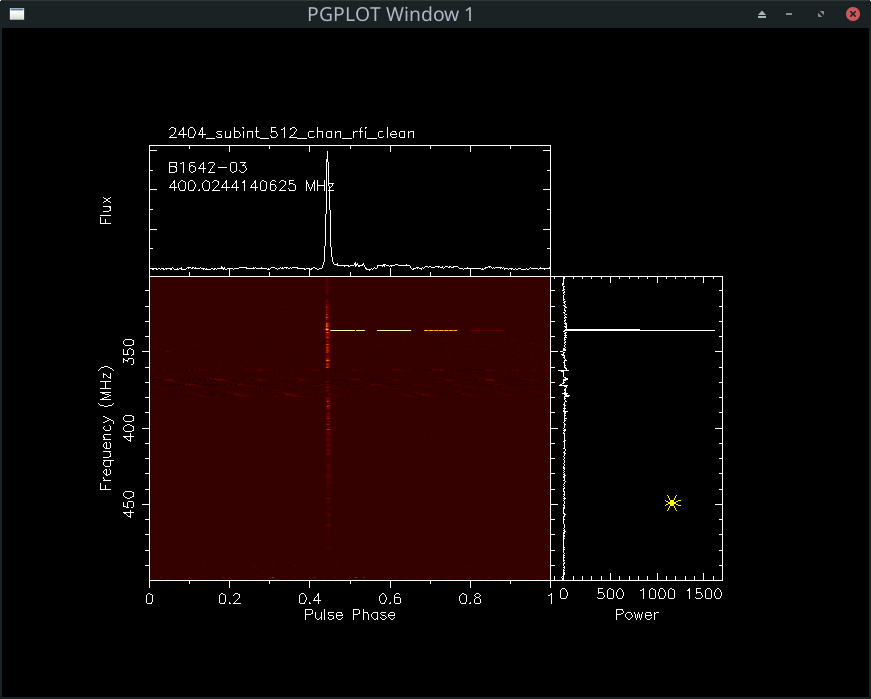

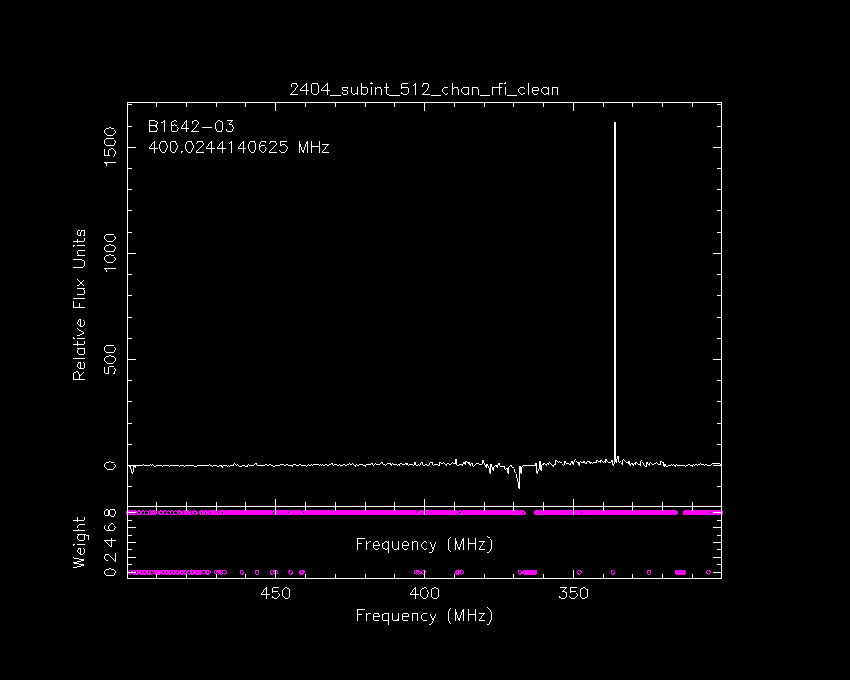

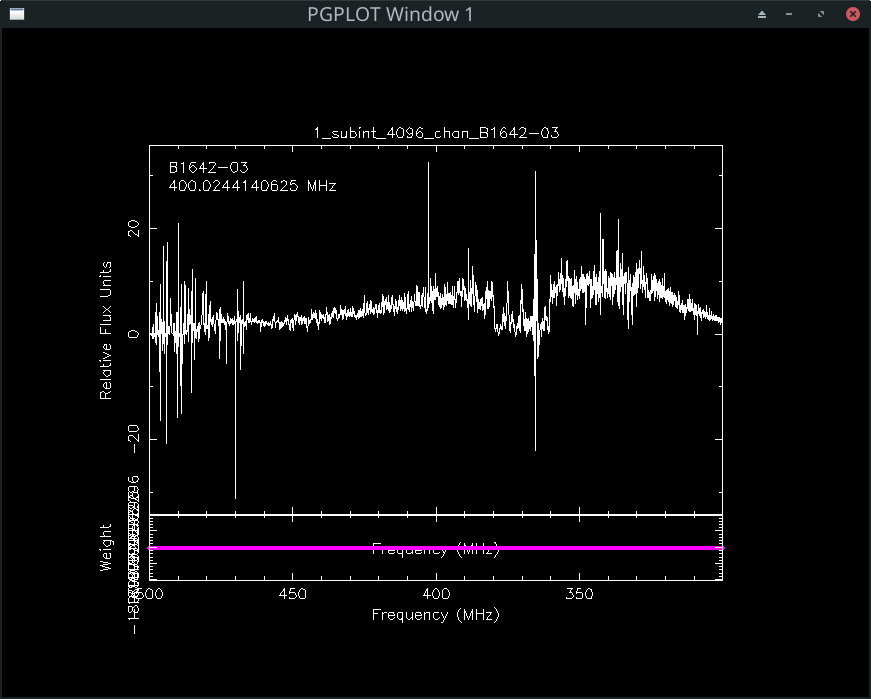

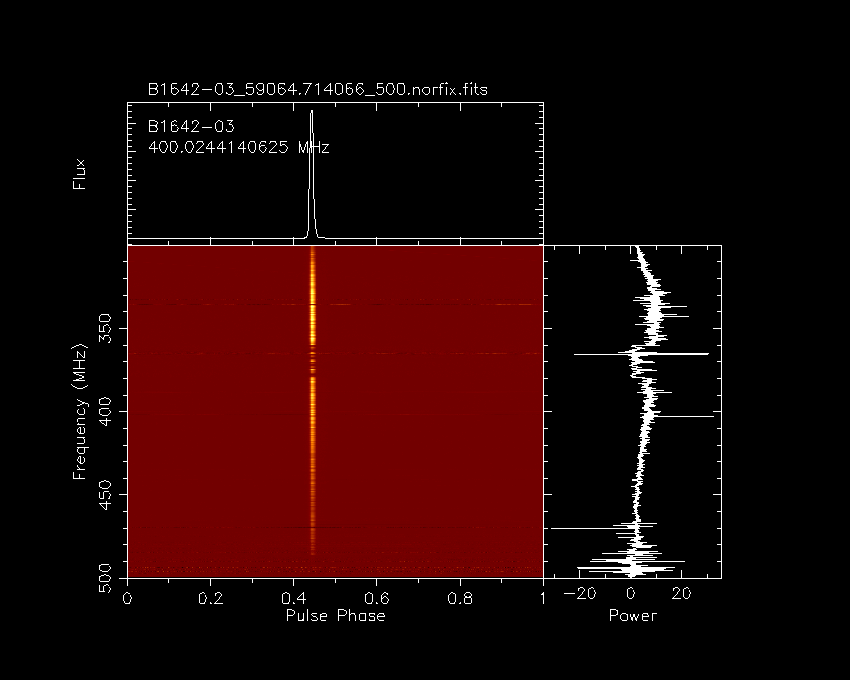

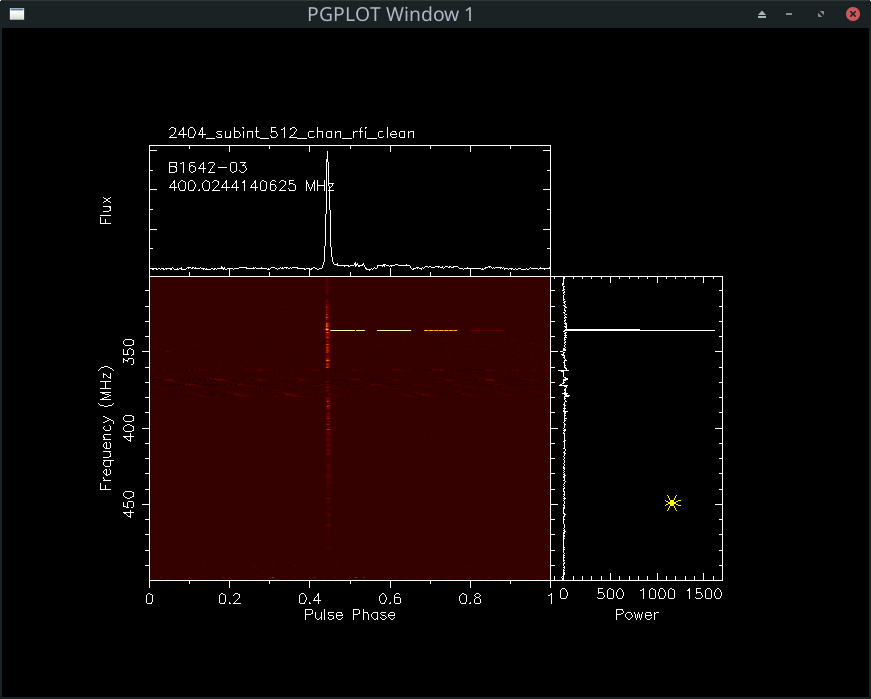

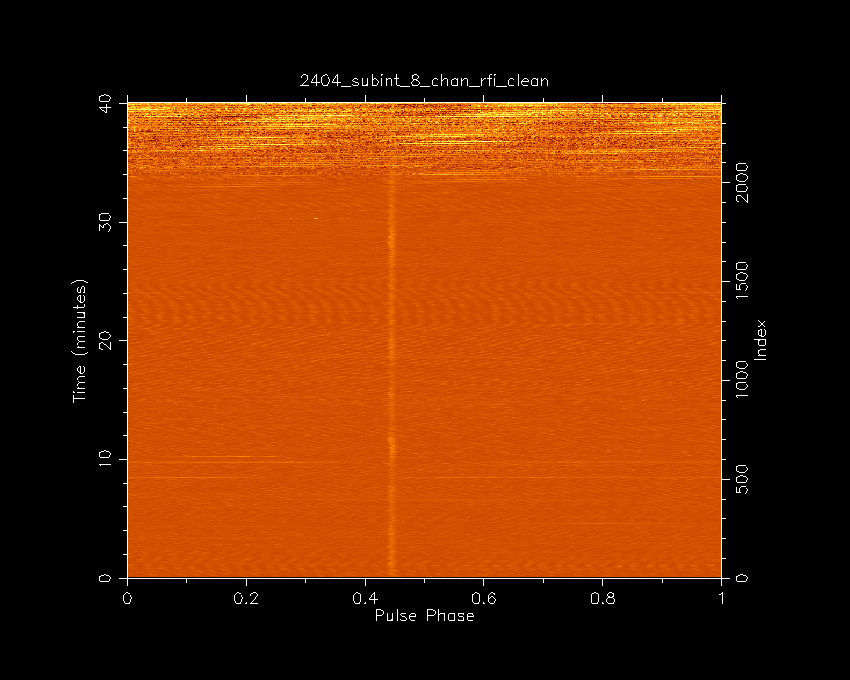

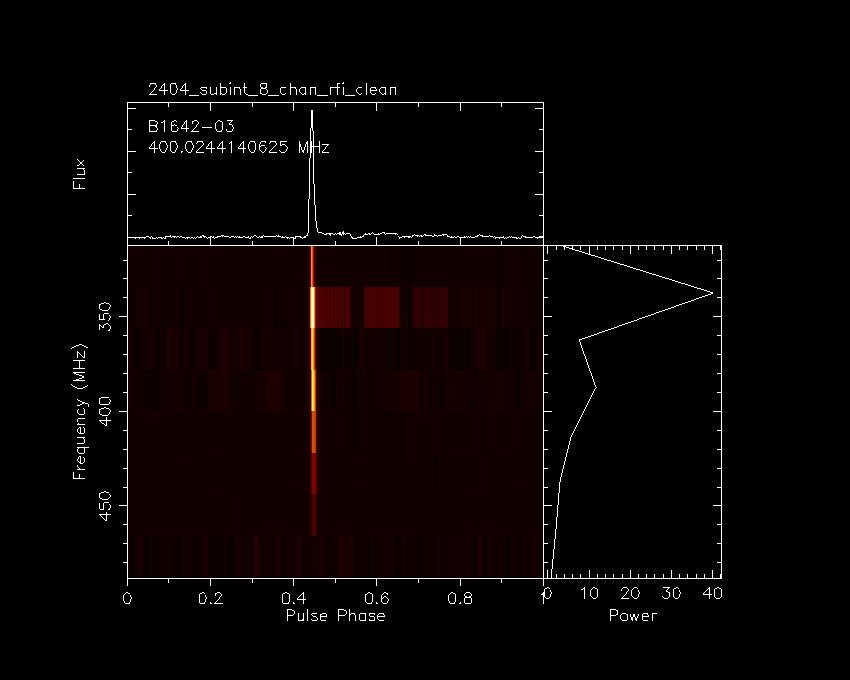

In [13]:
RFI_clean512=psrchive.Archive_load("../2404_subint_512_chan_rfi_clean")
RFI_cleaned=psrchive.Archive_load("../2404_subint_8_chan_rfi_clean")

In [15]:
data_8chan=RFI_cleaned.get_data()

In [20]:
data_8chan.size

9846784

In [24]:
data_512chan=RFI_clean512.get_data()

In [186]:
archive_temp=psrchive.Archive_load("../Analysis4.1/500_1_rfi.tt")

In [187]:
data=archive_temp.get_data()

In [190]:
data.shape

(1, 1, 1, 512)

In [191]:
data2=(data[0,0,0,:])

In [192]:
data2.shape

(512,)

In [193]:
SNR(data2,200,260)

[3259.6929, 0.037315894, 0.049571067, 65757.97]

# Extracting TOA errors from .tim files

In [2]:
import os

# Function to extract text from .tim files in a folder
def extract_text_from_tim(folder_path):
    # Iterate over all files in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith(".tim"):
            file_path = os.path.join(folder_path, filename)
            try:
                # Extract text from .tim file
                text = textract.process(file_path)
                print(f"Extracted text from {filename}:")
                print(text.decode("utf-8"))  # Decode bytes to string and print
            except Exception as e:
                print(f"Error extracting text from {filename}: {e}")

# Path to the folder containing .tim files
folder_path = "/path/to/your/folder"

# Call the function to extract text
extract_text_from_tim(folder_path)
?

ModuleNotFoundError: No module named 'textract'

In [14]:
%cd ../../NIUS_Jitter_Project/Analysis/Analysis4.0/tim_files/

/home/ega-ninja/Projects/NIUS_Jitter_Project/Analysis/Analysis4.0/tim_files


In [22]:
file=open(file_path,'r')
data_file=file.read()

In [59]:
def get_toa_erro(file_path):
    # Open the .tim file for reading
    with open(file_path, "r") as file:
        # Read all lines from the file and store them in an array
        lines_array = file.readlines()

    toa_error=np.zeros(len(lines_array)-1)
    for i in range(1,len(lines_array)):
        line = lines_array[i]
        a=line.split()
        toa_error[i-1]=a[-2]
    return toa_error


In [99]:
file_path1="10_subint_8chan_chan8.tim"

In [100]:
a1=get_toa_erro(file_path1)
a1

array([0.971, 0.876, 1.13 , 0.884, 0.694, 1.43 , 0.902, 1.671, 1.478,
       3.769])

In [101]:
a1[:-2]

array([0.971, 0.876, 1.13 , 0.884, 0.694, 1.43 , 0.902, 1.671])

In [102]:
np.mean(a1[:-2])


1.06975

In [103]:
np.std(a1[:-2])

0.30537548608229836

# Jitter Estimation

$\sigma_{jitter}^2(T)$ = $\sigma_{obs}^2(T)$ - $\sigma_{rad}^2(T)$

We have estimated jitter for { 0.067 hr} Time

In [126]:
d1={ 'freq(MHz)' : np.array([488.151, 461.851, 437.08 , 413.063, 387.487, 362.054, 337.372,312.277]) ,
    'post_fit_rms': [ 19.56,21.59,21.71,24.80,25.22,20.49,23.92,21.41] ,
    'TOA_error': [ 23.45,1.62,1.17,1.11,1.15,1.43,1.19,1.07] ,
    'sigma':[2.91,0.22,0.25,0.30,0.28,0.32,0.34,0.30 ]
}

In [127]:
df1=pd.DataFrame(d1)
df1
Jitter= np.sqrt(((np.array(df1.iloc[:,1]))**2) -( (np.array(df1.iloc[:,2]))**2)) 

/tmp/ipykernel_55669/2564746068.py:3: RuntimeWarning: invalid value encountered in sqrt
  Jitter= np.sqrt(((np.array(df1.iloc[:,1]))**2) -( (np.array(df1.iloc[:,2]))**2))


In [128]:
df1['Jitter(us)']=Jitter

In [130]:
df2=df1.iloc[1:,:]

In [131]:
df2

,freq(MHz),post_fit_rms,TOA_error,sigma,Jitter(us)
1,461.851,21.59,1.62,0.22,21.529136
2,437.080,21.71,1.17,0.25,21.678450
3,413.063,24.80,1.11,0.30,24.775147
4,387.487,25.22,1.15,0.28,25.193767
5,362.054,20.49,1.43,0.32,20.440039
6,337.372,23.92,1.19,0.34,23.890381
7,312.277,21.41,1.07,0.30,21.383246


In [138]:
np.mean(df2.iloc[:,4])

22.698595133508547

In [137]:
#plotting
# linear regression with error bars

x=np.array(df2.iloc[:,0])
y=np.array(df2.iloc[:,4])
#INPUT PARAMETERS


#dx = 

dy =  np.array(df2.iloc[:,3])

xlabel = "$ frequency (MHz) $"
ylabel = " $\sigma_{Jitter} (\mu s) $"


x1=np.linspace(np.min(x), np.max(x) , 10) # creates array for plotting the line

# defining linear function
def line(x,m,c):
    return (m*x + c)

var,pcov=curve_fit(line,x,y) # var contains the returned the optimized variables namely m ,c  

#print(np.sqrt(pcov))

#error bars
#xerror=np.full(shape=len(x),fill_value=dx ,)
yerror=np.full(shape=len(y),fill_value=dy ,)


#plotting the values and error bars
plt.errorbar(x, y,yerr = yerror,fmt ='.',capsize=2,color='black')
plt.scatter(x,y,color="r",marker="o")

#plt.plot(x1,line(x1,*var),label= ylabel ,color='green')


#

#plotting other important elements
st=str("variables")+str(var)
st1=str("covariance")+str(pcov)

plt.ylabel(ylabel)
plt.xlabel(xlabel)

plt.legend()
#plt.figtext(0.20, 0.76, st) # prints the string st at specified coordinates
#plt.figtext(0.20,0.62,st1)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
